#Resume Job Description Matching

## Install dependencies

In [ ]:
'''
Gensim and SpaCy need an older version of pandas. It is
therefore necessary to uninstall and reinstall an older version
pandas (v1.24.4) that is compatible with the library to avoid
dependency clashes. At the same time it it necessary to install older
versions of other libraries that will be imported in the project and
depend on the latest version of pandas. Once installation is complete
it is necessary to restart the session before running the next cells.
'''
# Uninstall conflicting versions to prevent dependency errors down the line.
!pip uninstall -y numpy pandas scipy matplotlib transformers thinc spacy gensim
# Reinstall compatible versions known to work together for this NLP task.
!pip install \
  numpy==1.25.2 \
  pandas==2.0.3 \
  scipy==1.10.1 \
  gensim==4.3.0 \
  transformers==4.30.0 \
  spacy==3.7.2 \
  matplotlib==3.7.1

import os
os.kill(os.getpid(), 9)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: scipy 1.15.2
Uninstalling scipy-1.15.2:
  Successfully uninstalled scipy-1.15.2
Found existing installation: matplotlib 3.10.0
Uninstalling matplotlib-3.10.0:
  Successfully uninstalled matplotlib-3.10.0
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: spacy 3.8.5
Uninstalling spacy-3.8.5:
  Successfully uninstalled spacy-3.8.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pi

## Import required libraries

In [ ]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import torch
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification,\
     LongformerTokenizer, LongformerForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

## Load the dataset and shuffle the data in it

The dataset which is on my github has the three classes (Good Fit, Potential Fit, No Fit) grouped together. This will lead to class imbalance in the training data which leads to poor predictive results. To handle this, shuffling has been done using the `.sample()` pandas method for better generalization.

In [ ]:
resume_match_df = pd.read_csv("https://raw.githubusercontent.com/samariwa/artificial-intelligence-projects/refs/heads/main/AI%20Assessment/data.csv").sample(frac=1)

`.sample(frac=1)` shuffles all rows. Smart move for avoiding overfitting to label ordering.

## Tokenization of text

Initialize SpaCy's English model that can be used to convert the resume and job description text into tokens that can be used to perform classification using various techniques. This involves making all characters lowercase, lemmatizing the text and removing stop words (which are of no significance in the classification).

In [ ]:
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
def tokenize_text(text):
    """
    tokenize_text(text)
    This function will tokenize the texts from the resumes and job descriptions
    This will be first preprocessed by removing stop words that add no semantic value
    and lemmatized for a standardized set of words
    text(string): the text to be tokenized
    returns: list of tokens generated from the text passed in as an arg
    """
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

### Perform the tokenization for each resume and each job description and store the list of tokens in their respective lists

Prepare two separate lists: one for resumes, one for job descriptions, each as lists of tokens.

In [ ]:
# initialize string that will contain tokens for each resume and job description
preprocessed_resume_text = []
preprocessed_jd_text = []
for i in tqdm(range(len(resume_match_df))):
    preprocessed_resume_text.append(tokenize_text(resume_match_df.iloc[i]['resume_text']))
    preprocessed_jd_text.append(tokenize_text(resume_match_df.iloc[i]['job_description_text']))

100%|██████████| 8000/8000 [22:05<00:00,  6.04it/s]


### Rejoin tokens and prepare corpus

For each resume and JD (job desription, rejoin the tokens into strings using the space " " delimiter.

Join the sets of words, resume_text and jd_text into one pool of words which woll be processed by the various vectorizers accordingly.

In [ ]:
# convert the tokens in each list back to strings
resume_texts = [" ".join(tokens) for tokens in tqdm(preprocessed_resume_text)]
jd_texts = [" ".join(tokens) for tokens in tqdm(preprocessed_jd_text)]
'''
combine the resume and job description texts before count vectorizing
In each row we represent the tokens as values counts for the number of
times they appear in the document
'''

corpus = resume_texts + jd_texts

100%|██████████| 8000/8000 [00:00<00:00, 108353.35it/s]


## Vectorization using the Bag of Words Vectorizer

1.   Initialize the BoW count vectorizer
2.   Transform the words into vectors which are represented by the number of times they appear in a sentence (the joined tokens)
3. Reseparate the resume and jd text and put them side-by-side (a resume with is correpsonding JD in one row). This will act as the features and the outcomes of the selection process as the labels.



In [ ]:
# initialize bag of words vectorizer
vectorizer = CountVectorizer()
# transform the corpus (resume + jd text) into vectors
bow_matrix = vectorizer.fit_transform(corpus)
# separate the resume and jd text and set them side-by-side
resume_bow = bow_matrix[:len(resume_texts)].toarray()
jd_bow = bow_matrix[len(resume_texts):].toarray()

In [ ]:
# we horizontally stack JDs and resumes so that we have numeric representations od words for JDs and corresponding resume
X = np.hstack((resume_bow, jd_bow))
# this representation created above will be set against the job-match decision
y = resume_match_df['label'].values

### K-Fold cross-validation Model Evaluation (BoW)

First it is necessary to establish which algorithm performs well for this problem. This can iteratively be done through cross-validation using several algorithms and this can be helpful is establishing how well generalized our data is.

In [ ]:
def classify_k_fold_x_validation(model, x_data, y_data, folds):
    """
    classify_k_fold_x_validation(model, x_data, y_data, folds)
    This function performs k-fold cross validation by running trainings and testing on
    different segments of the dataset. The number of segments id defined as an argument
    model: The model being used for cross-validation
    x_data: the set of features in the data
    y_data: the labels of the data
    folds: The value of k representing the number of divisions of the data to be done for cross-validation
    """
    # list to store accuracy for each model
    accuracy_scores = []
    classifier = model()
    k_fold = KFold(n_splits=folds, shuffle=False)
    # For each fold(split) run classification and get the accuracy metric
    for train_idx, test_idx in k_fold.split(x_data):
        X_train, X_test, y_train, y_test = x_data[train_idx], x_data[test_idx], y_data[train_idx], y_data[test_idx]
        classifier.fit(X_train, y_train)
        accuracy_scores.append(classifier.score(X_test, y_test))

    return accuracy_scores

In [ ]:
def model_validation(x_data, y_data, folds=10):
    """
    model_validation(x_data, y_data, folds=10)
    Validates performance of various models
    It passes each algorithm specified in the `models` list
    to the classify_k_fold_x_validation(model, x_data, y_data, folds)
    function together with feature and labels and the number of folds
    expected.
    """
    models = {'K-Nearest Neighbors': 'KNeighborsClassifier',
              'Decision Tree': 'DecisionTreeClassifier',
              'Random Forest': 'RandomForestClassifier',
              'Support Vector Classifier': 'SVC',
              'Gaussian Naive Bayes': 'GaussianNB'}
    model_performance = {}
    # For each model run cross-validation
    for model_name, model_function in tqdm(models.items()):
        accuracies = classify_k_fold_x_validation(eval(model_function), x_data, y_data, folds)
        model_performance[model_name] = accuracies
    plt.figure(figsize=(12, 6))
    # Visualize each model's accuracy in a box and whisker plot
    plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))
    plt.title('Classification Performance Comparison with K-Fold Cross Validation')
    plt.xlabel('Classifier Model')
    plt.ylabel('Accuracy Scores')
    plt.show()

100%|██████████| 5/5 [3:35:12<00:00, 2582.47s/it]


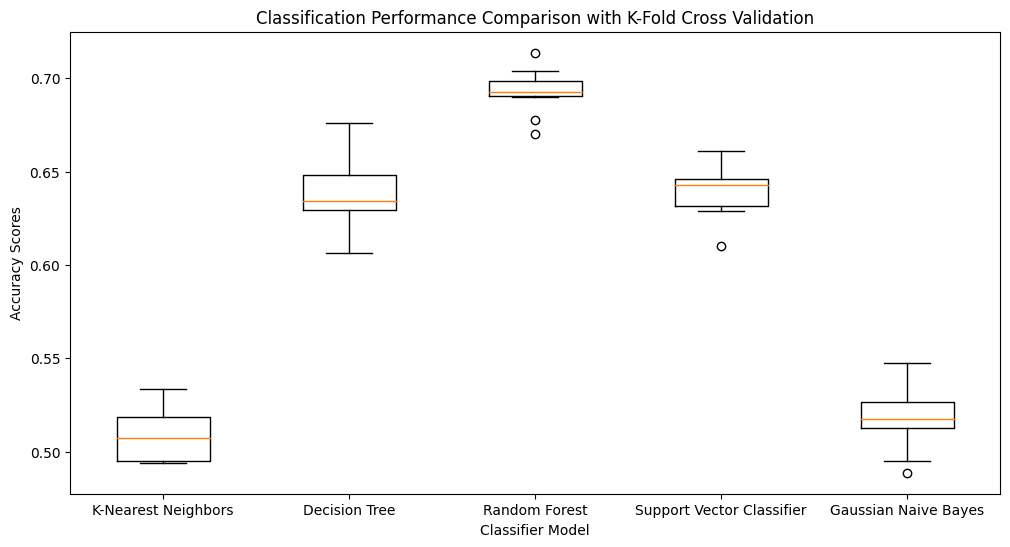

In [ ]:
# Get the performance of the various algorithms using 10 folds
model_validation(X, y, folds=10)

As an ensemble algorithm, `Random Forest Classifier` (combination of several decision trees) took the longest time to run during validation but was able to achieve the best results. The box and whisker plot shows a lower variance in the results of the algorithm which was the highest with a median of around 69%. It is the model to be used in this Bag of Words technique and will be optimized using hyperparameter tuning for the best results.

### Algorithm optimization and classification of the data (BoW)

In [ ]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Evaluate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: {conf_matrix}")

# Evaluate the classification report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report: {class_report}")

Model Accuracy: 0.69


## Results

Based on the results, the algorithm got an accuracy of `` which is not so good. It classifies the resumes and JDs on the basis if word count which has some level of relationship with the labels but does lack further explainability.

However, the bag of words technique lacks semantic meaning of the words for purpose of evaluating their importance and relationships with each other. For this reason, the tokens generated lack contextual meaning and therefore is not a reliable technique for resume-jobs matching.

I will use a different vectorizer that works differently for comparison purposes.

## Vectorization using TF-IDF

1. Initialize the TF-IDF vectorizer  
2. Separately convert the resume and JD text into TF-IDF representations  
3. Horizontally stack them as features  

In [ ]:
# initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
# Vectorize each document (joined tokens) in resume and JD separately
resume_tfidf = tfidf_vectorizer.fit_transform(resume_texts)
jd_tfidf = tfidf_vectorizer.fit_transform(jd_texts)

In [ ]:
# Stack the resume and JD vectors side-by-side
X = hstack((resume_tfidf, jd_tfidf)).toarray()

# Set the labels as the expected outcome
y = resume_match_df['label'].values

### K-Fold cross-validation Model Evaluation (TF-IDF)

100%|██████████| 5/5 [2:19:35<00:00, 1675.04s/it]


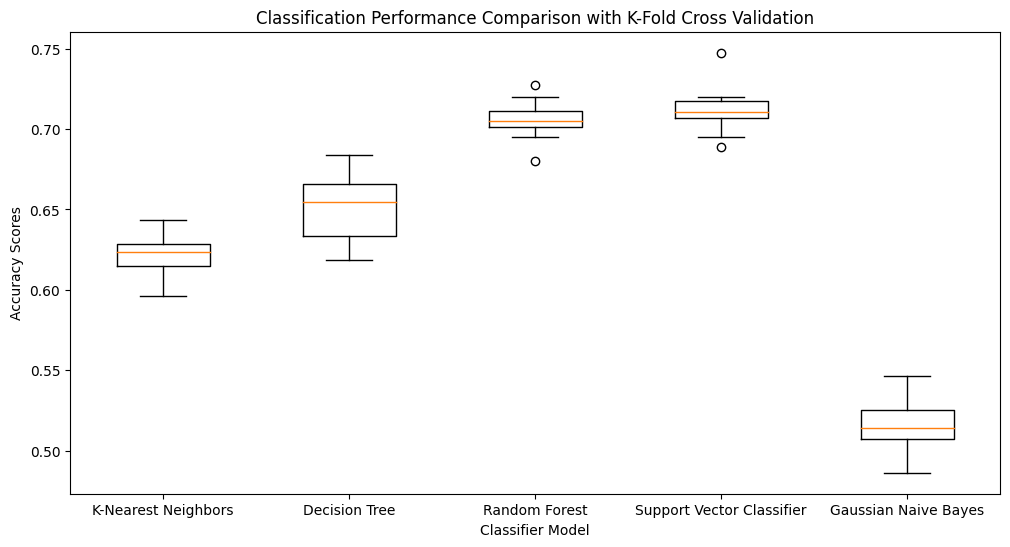

In [ ]:
# Run cross-validation on the TF-IDF features using all defined models
model_validation(X, y, folds=10)

Support Vector Machine is used here because it showed good performance in cross-validation. The box and whisker plot shows a lower variance in the results of the algorithm which was the highest with a median of around 72%.

### Algorithm optimization and classification of the data (TF-IDF)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best classifier
clf = SVC()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Evaluate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: {conf_matrix}")

# Evaluate the classification report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report: {class_report}")

Model Accuracy: 0.69


## Results

Based on the results, the algorithm got an accuracy of `` which is slightly better. It classifies the resumes and JDs on the basis of weighted word importance per document which also has some level of relationship with the labels but still doesn't solve the explainability issue completely.

The TF-IDF technique gives us high-level and per-class performance metrics.

So far the best performances for the techniques are as follows:

Bag-of-Words: 69%

TF-IDF: 72%

TF-IDF generated tokens can also be used in getting cosine similarities between the resumes and JDs. This similarity value can be used categorizing the values into labels (Good Fit, Potential Fit, No Fit)

### TF-IDF Cosine Similarity Evaluation

Cosine similarity gives us a number from 0 to 1. A higher values means more similarity.

We combine resume and JD text together because cosine similarity compares vectors of the same dimension

In [ ]:
# Combine all text into a single matrix to maintain same feature dimensions
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# split back to resume and jd matrices
cos_sim_resume_tfidf = tfidf_matrix[:len(resume_texts)]
cos_sim_jd_tfidf = tfidf_matrix[len(resume_texts):]

# For each resume-JD pair, compute cosine similarity score
similarity_scores = [cosine_similarity(cos_sim_resume_tfidf[i], cos_sim_jd_tfidf[i])[0][0] for i in range(len(resume_tfidf.toarray()))]

#### Identifying the best threshold to categorize the similarity scores.

In [ ]:
# classify based on fixed similarity thresholds
def classify_similarity_scores(scores):
  """
  classify_similarity_scores(scores)
  Converts cosine similarity scores in to suitablility labels
  scores: list of cosine similarity scores
  returns: list of labels
  """
  similarity_scores = []
  for score in scores:
    if score >= 0.2:
      # score is good
      similarity_scores.append("Good Fit")
    elif score >= 0.1 and score < 0.2:
      similarity_scores.append("Potential Fit")
    elif score < 0.1:
      similarity_scores.append("No Fit")

  predictions = pd.DataFrame(similarity_scores)

  return predictions

cos_sim_pred = classify_similarity_scores(similarity_scores)

In [ ]:
# Evaluate Model
accuracy = accuracy_score(y, cos_sim_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Evaluate the confusion matrix
conf_matrix = confusion_matrix(y, cos_sim_pred)
print(f"Confusion Matrix: {conf_matrix}")

# Evaluate the classification report
class_report = classification_report(y, cos_sim_pred)
print(f"Classification Report: {class_report}")

Model Accuracy: 0.49


This method of classification gave a poor result. This indicates the `cosine similarity` of a resume and job description does not directly denote the matching level(Good Fit, Potential Fit, No Fit). This can be seen by the analysis below.

In [ ]:
y_df = pd.DataFrame(y)
no_fit_actual = y_df.loc[y_df[0] == "No Fit"].count()[0]
pot_fit_actual = y_df.loc[y_df[0] == "Potential Fit"].count()[0]
good_fit_actual = y_df.loc[y_df[0] == "Good Fit"].count()[0]
no_fit_pred = cos_sim_pred.loc[cos_sim_pred[0] == "No Fit"].count()[0]
pot_fit_pred = cos_sim_pred.loc[cos_sim_pred[0] == "Potential Fit"].count()[0]
good_fit_pred = cos_sim_pred.loc[cos_sim_pred[0] == "Good Fit"].count()[0]
print(f"Good Fit Predictions Count:{good_fit_pred}...Good Fit Actual Count:{good_fit_actual}")
print(f"Potential Fit Predictions Count:{pot_fit_pred}...Potential Fit Actual Count:{pot_fit_actual}")
print(f"Not Fit Predictions Count:{no_fit_pred}...Not Fit Actual Count:{no_fit_actual}")

Good Fit Predictions Count:364...Good Fit Actual Count:2000
Potential Fit Predictions Count:1849...Potential Fit Actual Count:2000
Not Fit Predictions Count:5787...Not Fit Actual Count:4000


NB: The results above do not substitute the `recall` metric.

I will use a different vectorizer that works differently for comparison purposes.

## Vectorization using word embeddings (Word2Vec)

This technique learns vector representations of words based on context.

In [ ]:
# Combine preprocessed resume and JD tokens for training Word2Vec
all_tokens = preprocessed_resume_text + preprocessed_jd_text

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average Word2Vec vector for a document
def get_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else model.vector_size

# Convert resumes & JDs into numerical vectors
resume_vectors = np.array([get_vector(tokens, word2vec_model) for tokens in preprocessed_resume_text])
jd_vectors = np.array([get_vector(tokens, word2vec_model) for tokens in preprocessed_jd_text])

# Combine resume and JD vectors side-by-side to form feature set
X = np.hstack((resume_vectors, jd_vectors))
y = resume_match_df['label'].values

### K-Fold cross-validation Model Evaluation (Word2Vec)

100%|██████████| 5/5 [02:19<00:00, 27.87s/it]


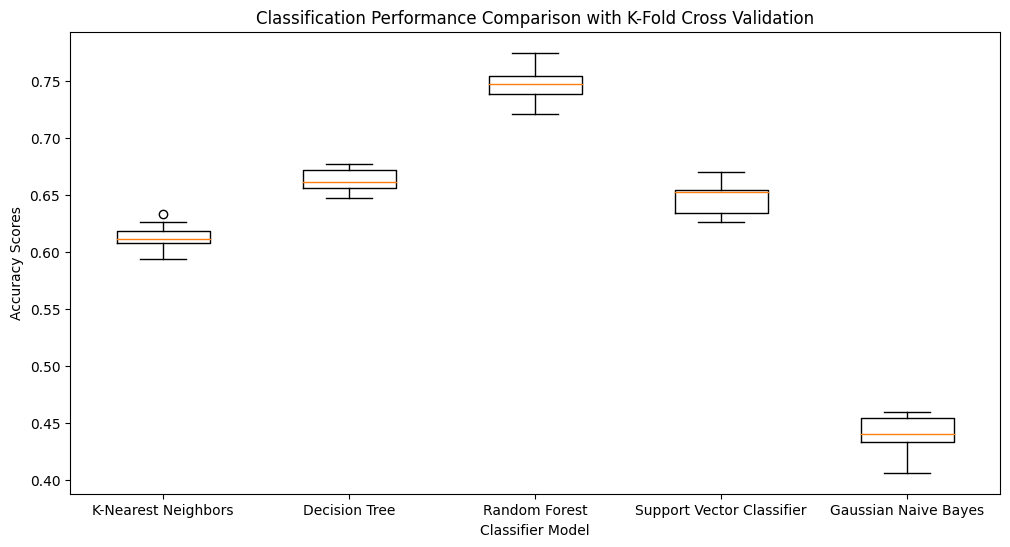

In [ ]:
# Run 10-fold cross-validation on the Word2Vec vectors
model_validation(X, y, folds=10)

For this technique, the Random Forest Classifier was able to achieve the best results. The box and whisker plot shows a lower variance in all the algorithms in the results but has the highest performance with a median of around 73%.

### Algorithm optimization and classification of the data (Word2Vec)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Evaluate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: {conf_matrix}")

# Evaluate the classification report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report: {class_report}")

Model Accuracy: 0.73


Based on the results, the algorithm got an accuracy of `73%` which is better. It classifies the resumes and JDs on the contextual meaning of the words contained in them. This brings out a better relationship with the labels.

The Word2Vec technique gives us high-level and per-class performance metrics.

So far the best performances for the techniques are as follows:

Bag-of-Words: 69%

TF-IDF: 72%

TF-IDF (Cosine Similarity): 49%

Word2Vec: 73%

Similarly to TF-IDF, Word2Vec generated tokens can also be used in getting cosine similarities between the resumes and JDs. This similarity value can be used categorizing the values into labels (Good Fit, Potential Fit, No Fit)

#### Word2Vec Cosine Similarity Evaluation

In [ ]:
similarity_scores_w2v = [cosine_similarity([cos_sim_resume_w2v], [cos_sim_jd_w2v])[0][0] for cos_sim_resume_w2v, cos_sim_jd_w2v in zip(resume_vectors, jd_vectors)]

In [ ]:
cos_sim_pred_w2v = classify_similarity_scores(similarity_scores_w2v)

In [ ]:
# Evaluate Model
accuracy = accuracy_score(y, cos_sim_pred_w2v)
print(f"Model Accuracy: {accuracy:.2f}")

# Evaluate the confusion matrix
conf_matrix = confusion_matrix(y,cos_sim_pred_w2v)
print(f"Confusion Matrix: {conf_matrix}")

# Evaluate the classification report
class_report = classification_report(y, cos_sim_pred_w2v)
print(f"Classification Report: {class_report}")

Model Accuracy: 0.29


This method of classification with Word2Vec gave the worst result. This indicates the `cosine similarity` of a resume and job description does not directly denote the matching level.

### Using Neural Network with word embeddings (Word2Vec & PyTorch)

In [ ]:
# Combine resume and JD vectors into single vectors
X = np.concatenate([resume_vectors, jd_vectors], axis=1)

# Encode labels and convert the features and labels to tensors
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert everything into PyTorch tensors
y_tensor = torch.tensor(y_encoded, dtype=torch.long)
X_tensor = torch.tensor(X, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [ ]:
# Set dimensions of the network
input_dimension = X.shape[1]
hidden_layers = 128
output_dimension = len(np.unique(y_encoded))

# Hyperparameter initialization
learning_rate = 0.01
epochs = 20
batch_size = 32

In [ ]:
# Randomly initialize weights and biases
W1 = torch.randn(input_dimension, hidden_layers, requires_grad=True)
W1.data *= 0.01

b1 = torch.zeros(hidden_layers, requires_grad=True)

# Weights and biases for output layer
W2 = torch.randn(hidden_layers, output_dimension, requires_grad=True)
W2.data *= 0.01

b2 = torch.zeros(output_dimension, requires_grad=True)

# Use Adam optimizer for weight updates
optimizer = torch.optim.Adam([W1, b1, W2, b2], lr=learning_rate)
# Standard multi-class loss function
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))  # shuffle

    epoch_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        # Forward pass
        z1 = batch_x @ W1 + b1  # Linear
        a1 = F.relu(z1)         # ReLu activation
        z2 = a1 @ W2 + b2       # Output layer
        loss = criterion(z2, batch_y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/20 - Loss: 190.5731
Epoch 2/20 - Loss: 170.1853
Epoch 3/20 - Loss: 157.8612
Epoch 4/20 - Loss: 150.2730
Epoch 5/20 - Loss: 146.2840
Epoch 6/20 - Loss: 141.8039
Epoch 7/20 - Loss: 135.5973
Epoch 8/20 - Loss: 131.8112
Epoch 9/20 - Loss: 128.7633
Epoch 10/20 - Loss: 126.7108
Epoch 11/20 - Loss: 124.3715
Epoch 12/20 - Loss: 119.9519
Epoch 13/20 - Loss: 119.5970
Epoch 14/20 - Loss: 115.0536
Epoch 15/20 - Loss: 114.7070
Epoch 16/20 - Loss: 113.1334
Epoch 17/20 - Loss: 111.6503
Epoch 18/20 - Loss: 108.6788
Epoch 19/20 - Loss: 107.7734
Epoch 20/20 - Loss: 106.6361


In [ ]:
with torch.no_grad():
    z1 = X_test @ W1 + b1
    a1 = F.relu(z1)
    z2 = a1 @ W2 + b2
    predictions = torch.argmax(z2, dim=1)

    # Compare predicted vs actual and get accuracy
    accuracy = (predictions == y_test).float().mean()
    print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7113


### Using DISTILBERT Pretrained model

In [ ]:
# Convert label to numeric classes
resume_match_df['label'] = resume_match_df['label'].map({'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2})

# Create a list of (resume, job_description) tuples for input
texts = [f"[RESUME] {resume} [SEP] [JOB] {job}" for resume, job in zip(resume_match_df['resume_text'], resume_match_df['job_description_text'])]
#texts = list(zip(resume_match_df['resume_text'], resume_match_df['job_description_text']))
# Extract labels into list
labels = resume_match_df['label'].tolist()

In [ ]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', num_labels=3)

#### Create a tokenization function

In [ ]:
def tokenize(texts, labels):
    """
    tokenize(texts, labels)
    """
    encodings = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(input_ids, attention_mask, labels_tensor)

#### Train/Test split

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_dataset = tokenize(X_train, y_train)
test_dataset = tokenize(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=8)

### Load the DistilBERT classification model

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
def train_model():
    """
    train_model()

    This function trains the DistilBERT classification model on the training dataset.
    It loops through the dataset for a defined number of epochs, performs forward
    propagation to calculate the loss, and then applies backpropagation to update
    the model weights using the Adam optimizer and a linear learning rate scheduler.

    returns: None. Prints the training loss for each epoch to track model convergence.
    """
    model.train()
    # train for 15 epochs over the training dataset
    for epoch in range(15):
        print(f"\nEpoch {epoch + 1}")
        loop = tqdm(train_loader)
        for batch in loop:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # backward pass
            loss.backward()
            # compute gradients
            optimizer.step()
            # update learning rate
            scheduler.step()
            optimizer.zero_grad()

            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())

train_model()

In [ ]:
def evaluate_model():
    """
    evaluate_model()
    This function evaluates the performance of the DistilBERT classification model
    on the test dataset. It disables gradient calculation, performs a forward pass
    to get predictions for each batch in the test set, and computes classification
    metrics to measure model performance.

    returns: None. Prints out a classification report comparing predicted labels
    to the actual labels in the test set.
    """
    model.eval()
    # store predictions and actual labels
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            # store predictions and actual labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # compute and print overall accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    print("\nClassification Report:\n")
    target_names = ['No Fit', 'Potential Fit', 'Good Fit']
    print(classification_report(all_labels, all_preds, target_names=target_names))

evaluate_model()


### Using Longformer(longformer-base-4096) Pretrained model

In [ ]:
resume_match_df['label'] = resume_match_df['label'].map({'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2})
texts = list(zip(resume_match_df['resume_text'], resume_match_df['job_description_text']))
labels = resume_match_df['label'].tolist()

In [ ]:
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
def tokenize(texts, labels):
    """
    Tokenize the input text pairs using Longformer.
    """
    combined_texts = [f"[CLS] {r} [SEP] {j}" for r, j in texts]
    encodings = tokenizer.batch_encode_plus(
        combined_texts,
        padding=True,
        truncation=True,
        max_length=4096,
        return_tensors='pt'
    )
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels, dtype=torch.long)
    )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_dataset = tokenize(X_train, y_train)
test_dataset = tokenize(X_test, y_test)

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=1)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=1)


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 3
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

def train_model():
    model.train()
    for epoch in range(3):
        print(f"\nEpoch {epoch + 1}")
        loop = tqdm(train_loader)
        for batch in loop:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())


In [ ]:
def evaluate_model():
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=['No Fit', 'Potential Fit', 'Good Fit']))
